# Part A

The following link has been used to develope the code : https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from itertools import groupby
from operator import itemgetter
from collections import Counter


In [2]:
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel

# v3.0
model_name_or_path = "HooshvareLab/bert-fa-base-uncased"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)




In [3]:
dict={0:"eraghi.txt", 1:"bahar.txt", 2:"farrokhi.txt", 3:"ferdousi.txt", 4:"moulavi.txt", 5:"parvin.txt", 6:"saadi.txt", 7:"saeb.txt", 8:"kamal.txt", 9:"khaghani.txt"}

In [4]:
linee=[]
for i in range(10):
    with open(str("./Desktop/"+dict[i]), encoding = 'utf-8') as file:
        linee.append([line.rstrip() for line in file])

In [5]:
lines=[]
for j in range(10):
    l=[linee[j][i] for i in range(len(linee[j])) if linee[j][i]!=""]
    lines.append(l)

In [6]:
liness=[]
for i in range(10):
    l=[[lines[i][x]+" "+lines[i][x+1], i] for x in range(2,11001,2)]
    liness.append(l)

In [7]:
import math
trainset=[]
testset=[]
for i in range(len(liness)):
    l=math.floor(0.9*len(liness[i]))
    train=liness[i][0:l][:]
    test=liness[i][l+1:-1][:]
    trainset.append(train)
    testset.append(test)

In [8]:
finaltrain=[]
finaltest=[]
for i in range(10):
    for j in range(len(trainset[i])):
        finaltrain.append(trainset[i][j]) 
        
for i in range(10):
    for j in range(len(testset[i])):
        finaltest.append(testset[i][j]) 

In [9]:
import random

random.shuffle(finaltrain)
random.shuffle(finaltest)


In [10]:
l1=max([len(finaltrain[i][0].split(" ")) for i in range(len(finaltrain))])
l2=max([len(finaltest[i][0].split(" ")) for i in range(len(finaltest))])
maxl=0
if l1>=l2:
    maxl=l1
else:
    maxl=l2
    
maxl

27

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [65]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_name_or_path)
        for params in self.bert.parameters():
            params.requires_grad=False
        self.linear = nn.Linear(768, 10)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        
        out = self.bert(inputs)
        #print(out[1].shape)
        linear_output = self.linear(out[1])

        return linear_output

In [ ]:
fcmodel = BertClassifier().to(device)

In [186]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcmodel.parameters(), lr=learning_rate) 


In [12]:
class newDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):

        self.labels = [dataset[i][1] for i in range(len(dataset))]
        self.texts = [ tokenizer(dataset[i][0], padding='max_length', max_length = maxl, truncation=True, return_tensors="pt")['input_ids'] for i in range(len(dataset))]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return torch.tensor(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [13]:
 train, test = newDataset(finaltrain), newDataset(finaltest)

In [181]:
trainloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=64)

In [14]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct=0
    for batch, (X, y) in enumerate(dataloader):
        X=X.squeeze(1).to(device)
        y=y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X=X.squeeze(1).to(device)
            y=y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [187]:
epochs=5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader, fcmodel, loss_fn, optimizer)
    test_loop(testloader, fcmodel, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.341294  [    0/49500]
loss: 2.140985  [ 6400/49500]
loss: 1.875100  [12800/49500]
loss: 2.013183  [19200/49500]
loss: 2.102238  [25600/49500]
loss: 1.954795  [32000/49500]
loss: 1.798768  [38400/49500]
loss: 1.823249  [44800/49500]
Test Error: 
 Accuracy: 36.2%, Avg loss: 1.834707 

Epoch 2
-------------------------------
loss: 1.762389  [    0/49500]
loss: 1.788150  [ 6400/49500]
loss: 1.804710  [12800/49500]
loss: 1.911430  [19200/49500]
loss: 1.646942  [25600/49500]
loss: 1.919959  [32000/49500]
loss: 1.658177  [38400/49500]
loss: 1.755023  [44800/49500]
Test Error: 
 Accuracy: 39.1%, Avg loss: 1.763526 

Epoch 3
-------------------------------
loss: 1.603127  [    0/49500]
loss: 1.569566  [ 6400/49500]
loss: 1.704071  [12800/49500]
loss: 1.610541  [19200/49500]
loss: 1.645939  [25600/49500]
loss: 1.650876  [32000/49500]
loss: 1.727077  [38400/49500]
loss: 1.506523  [44800/49500]
Test Error: 
 Accuracy: 41.3%, Avg loss: 1.715615 

Epoc

In [188]:
torch.save(fcmodel,"PartA.pth")

In [15]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0]
            y=dataset[i][1].item()
            pred = model(X).argmax(1)[0].item()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [191]:
p, r=evaluation(test, fcmodel.to("cpu"))


In [195]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(r, p, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cf_mat

array([[131,  32,   4,  35, 138,  91,  27,  23,  21,  46],
       [ 23, 124,  22,  38,  41,  91,  30,  55,  11, 113],
       [ 13, 110, 146,  60,  65,  38,  15,  40,  13,  48],
       [  2,  40,  13, 369,  56,  27,   4,  11,   8,  18],
       [  6,  37,  15,  28, 311,  41,  14,  39,  16,  41],
       [ 17,  47,   3,  19,  27, 385,   8,  25,   8,   9],
       [ 26,  27,  12,  17,  51,  28, 232,  53,  25,  77],
       [ 33,  24,   1,   2,   5,  60,  40, 312,  17,  54],
       [ 11, 125,  34,   8,  61,  29,  16,  85, 144,  35],
       [  9,  98,   3,  40,  57,  19,  40, 106,  35, 141]], dtype=int64)

In [193]:
from sklearn.metrics import f1_score
score = f1_score(r, p, average="micro")
score

0.4187956204379562

<AxesSubplot:>

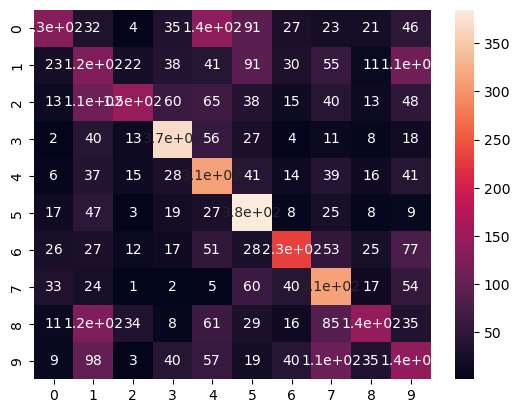

In [194]:
import seaborn as sns
sns.heatmap(cf_mat, annot=True)

# Part b

### Adam

In [28]:
from transformers import BertModel
class BertClassifierfinetune(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifierfinetune, self).__init__()

        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        #self.bert.train()
        self.linear = nn.Linear(768, 10)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        
        out = self.bert(inputs)
        #print(out[1].shape)
        linear_output = self.linear(out[1])

        return linear_output

In [16]:
fcmodelfinetune = BertClassifierfinetune().to(device)
fcmodelfinetune.train()
fcmodelfinetune.train

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<bound method Module.train of BertClassifierfinetune(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [18]:
learning_rate = 1e-5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fcmodelfinetune.parameters(), lr=learning_rate) 


In [19]:
trainloader1 = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
testloader1 = torch.utils.data.DataLoader(test, batch_size=4)

In [20]:
epochs=3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader1, fcmodelfinetune, loss_fn, optimizer)
    test_loop(testloader1, fcmodelfinetune, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.336251  [    0/49500]
loss: 2.376417  [  400/49500]
loss: 2.108502  [  800/49500]
loss: 1.879384  [ 1200/49500]
loss: 2.096700  [ 1600/49500]
loss: 2.002661  [ 2000/49500]
loss: 1.645929  [ 2400/49500]
loss: 2.075792  [ 2800/49500]
loss: 1.024950  [ 3200/49500]
loss: 1.414879  [ 3600/49500]
loss: 1.639745  [ 4000/49500]
loss: 2.027227  [ 4400/49500]
loss: 1.145186  [ 4800/49500]
loss: 1.368487  [ 5200/49500]
loss: 1.974430  [ 5600/49500]
loss: 1.774034  [ 6000/49500]
loss: 1.272773  [ 6400/49500]
loss: 1.280575  [ 6800/49500]
loss: 1.384660  [ 7200/49500]
loss: 1.429259  [ 7600/49500]
loss: 1.789186  [ 8000/49500]
loss: 1.130280  [ 8400/49500]
loss: 1.820530  [ 8800/49500]
loss: 0.452401  [ 9200/49500]
loss: 1.722324  [ 9600/49500]
loss: 1.488455  [10000/49500]
loss: 1.591915  [10400/49500]
loss: 0.541468  [10800/49500]
loss: 1.318138  [11200/49500]
loss: 1.947391  [11600/49500]
loss: 0.763088  [12000/49500]
loss: 1.196582  [12400/49500]


KeyboardInterrupt: 

In [42]:
torch.save(fcmodelfinetune,"PartB_Adam.pth")

In [22]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        #for i in range(10):
        for i in range(len(dataset)):
            X=dataset[i][0]
            y=dataset[i][1].item()
            pred = model(X).argmax(1)[0].item()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [24]:
p, r=evaluation(test, fcmodelfinetune.to("cpu"))


In [25]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(r, p, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cf_mat

array([[272,  36,   2,  11, 106,  47,  31,   6,  20,  17],
       [ 49, 211,  18,  12,  35,  55,  44,  17,  16,  91],
       [  6,  70, 323,  43,  42,   7,  19,  10,  12,  16],
       [  0,  13,   3, 513,   6,   5,   3,   2,   2,   1],
       [ 13,  19,   6,   4, 459,  10,  13,   4,  10,  10],
       [  9,  46,   0,   5,  16, 433,   3,  22,   5,   9],
       [ 34,   5,   2,   3,  27,  10, 307,  10,   8, 142],
       [ 17,  18,   1,   0,   2,  10,  46, 415,   5,  34],
       [ 22, 124,  16,   3,  18,   3,  18,  15, 317,  12],
       [ 33, 145,   1,   8,  30,   8,  34,  11,  21, 257]], dtype=int64)

In [26]:
from sklearn.metrics import f1_score
score = f1_score(r, p, average="micro")
score

0.6399635036496351

<AxesSubplot:>

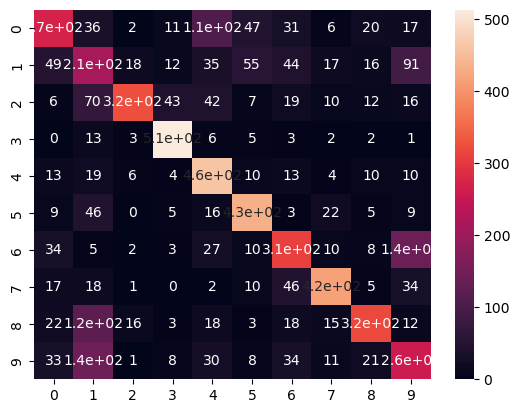

In [27]:
import seaborn as sns
sns.heatmap(cf_mat, annot=True)

### SGD

In [28]:
fcmodelfinetune_SGD = BertClassifierfinetune().to(device)
fcmodelfinetune_SGD.train()
fcmodelfinetune_SGD.train

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<bound method Module.train of BertClassifierfinetune(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((7

In [29]:
learning_rate = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fcmodelfinetune_SGD.parameters(), lr=learning_rate) 


In [30]:
trainloader2 = torch.utils.data.DataLoader(train, batch_size=4, shuffle=True)
testloader2 = torch.utils.data.DataLoader(test, batch_size=4)

In [31]:
epochs=2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(trainloader2, fcmodelfinetune_SGD, loss_fn, optimizer)
    test_loop(testloader2, fcmodelfinetune_SGD, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.346964  [    0/49500]
loss: 2.446268  [  400/49500]
loss: 2.326863  [  800/49500]
loss: 2.248284  [ 1200/49500]
loss: 2.230491  [ 1600/49500]
loss: 2.202624  [ 2000/49500]
loss: 2.331406  [ 2400/49500]
loss: 2.354017  [ 2800/49500]
loss: 2.394318  [ 3200/49500]
loss: 2.187480  [ 3600/49500]
loss: 2.145197  [ 4000/49500]
loss: 2.381254  [ 4400/49500]
loss: 2.270730  [ 4800/49500]
loss: 2.247681  [ 5200/49500]
loss: 2.094001  [ 5600/49500]
loss: 1.772188  [ 6000/49500]
loss: 2.141500  [ 6400/49500]
loss: 2.072478  [ 6800/49500]
loss: 2.170945  [ 7200/49500]
loss: 1.754898  [ 7600/49500]
loss: 2.531257  [ 8000/49500]
loss: 2.031117  [ 8400/49500]
loss: 1.971982  [ 8800/49500]
loss: 2.196084  [ 9200/49500]
loss: 2.173598  [ 9600/49500]
loss: 2.364690  [10000/49500]
loss: 2.369835  [10400/49500]
loss: 2.212990  [10800/49500]
loss: 2.343096  [11200/49500]
loss: 2.190801  [11600/49500]
loss: 2.076723  [12000/49500]
loss: 2.034836  [12400/49500]


In [70]:
torch.save(fcmodelfinetune_SGD,"PartB_SGD.pth")

In [33]:
def evaluation(dataset, model):
    predicted=[]
    real=[]
    with torch.no_grad():
        for i in range(len(dataset)):
            X=dataset[i][0]
            y=dataset[i][1].item()
            pred = model(X).argmax(1)[0].item()
            predicted.append(pred)
            real.append(y)
    return predicted, real

In [34]:
p, r=evaluation(test, fcmodelfinetune_SGD.to("cpu"))


In [35]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(r, p, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cf_mat

array([[159,   8,  12,  83,  68,  82,  48,   2,  32,  54],
       [ 41,  80,  62,  71,  58,  76,  54,  22,  27,  57],
       [ 11,  41, 264, 111,  46,  16,  12,  14,  18,  15],
       [  3,   8,  15, 486,  19,   6,   5,   0,   4,   2],
       [  7,  12,  27,  70, 331,  13,  27,   6,  33,  22],
       [ 25,  13,   9,  35,  21, 422,   9,  10,   3,   1],
       [ 14,  12,  24,  11,  36,  14, 366,  25,  23,  23],
       [ 51,  24,   1,   0,  10,  42, 139, 265,   8,   8],
       [ 14,  63, 105,  10,  58,  24,  59,  42, 145,  28],
       [ 12,  90,  33,  27,  70,   9, 116,  39,  51, 101]], dtype=int64)

In [36]:
from sklearn.metrics import f1_score
score = f1_score(r, p, average="micro")
score

0.4779197080291971

<AxesSubplot:>

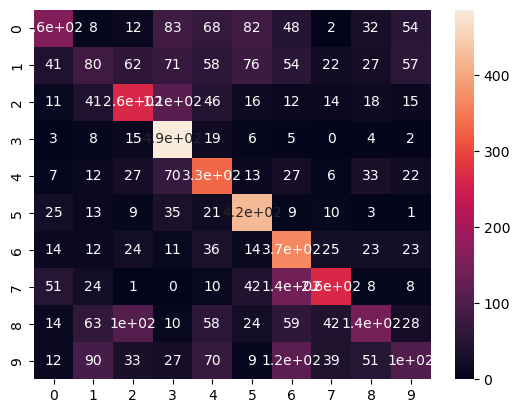

In [37]:
import seaborn as sns
sns.heatmap(cf_mat, annot=True)


# Part c

In [15]:
linee=[]
for i in range(10):
    with open(str("./Desktop/"+dict[i]), encoding = 'utf-8') as file:
        linee.append([line.rstrip() for line in file])

In [16]:
lines=[]
for j in range(10):
    l=[linee[j][i] for i in range(len(linee[j])) if linee[j][i]!=""]
    lines.append(l)

In [17]:
liness=[]
for i in range(10):
    l=[[lines[i][x]+" "+lines[i][x+1], i] for x in range(2,202,2)]
    liness.append(l)

In [19]:
newset=[]
for i in range(len(liness)):
    new=liness[i][:][:]
    newset.append(new)
    

In [21]:
data=[]
for i in range(10):
    for j in range(len(newset[i])):
        data.append(newset[i][j]) 
        


In [23]:
newdata = newDataset(data)

In [25]:
dataloaderr = torch.utils.data.DataLoader(newdata, batch_size=64, shuffle=False)


In [26]:
loss_fn = nn.CrossEntropyLoss()

def Perplexity(dataloader, model, loss_fn):
    correct=0
    loss=0
    for batch, (X, y) in enumerate(dataloader):
        X=X.squeeze(1).to(device)
        y=y.to(device)
        pred = model(X)
        loss =+ loss_fn(pred, y)
        #loss /= num_batches

    perplexity  = torch.exp(loss)
    print('Loss:', loss.item(), 'Perplexity:', perplexity.item())  

In [68]:
fcmodel2 = torch.load("PartA.pth")
print("Perplexity and Loss before fine_tuning :")
Perplexity(dataloaderr,fcmodel2.to(device),loss_fn)


Perplexity and Loss before fine_tuning :
Loss: 1.4879958629608154 Perplexity: 4.428211688995361


In [29]:
fcmodelfinetune_Adam = torch.load("PartB_Adam.pth")
print("Perplexity and Loss after fine_tuning :")
Perplexity(dataloaderr,fcmodelfinetune_Adam.to(device),loss_fn)


Perplexity and Loss after fine_tuning :
Loss: 0.2918351888656616 Perplexity: 1.338882327079773


fine_tuning with Adam optimizer decreases loss and Perplexity.